[*********************100%***********************]  2 of 2 completed

45 46



/var/folders/hm/1hdk35ys09q01dr03wnx7cn40000gn/T/ipykernel_23251/952480030.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cumulative_returns = cumulative_returns.fillna(method='ffill').fillna(0)


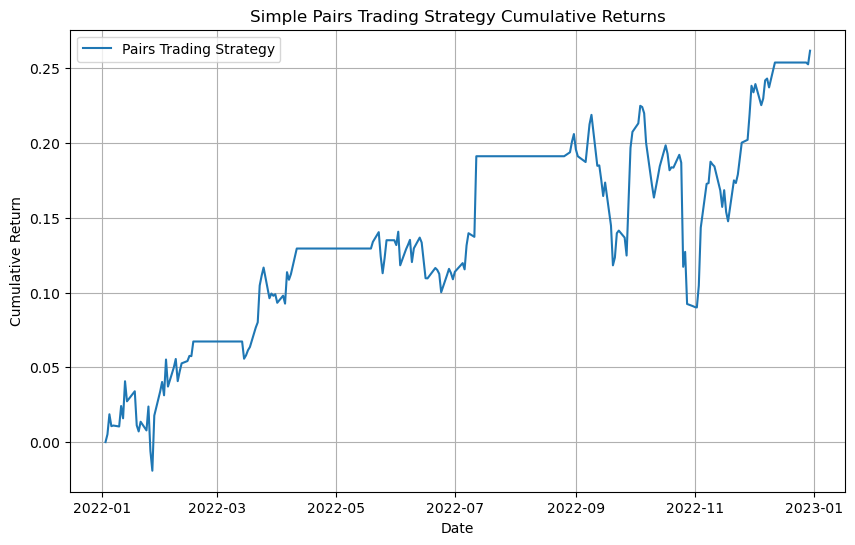

Date
2022-01-03    0.000000
2022-01-04    0.005196
2022-01-05    0.018607
2022-01-06    0.010645
2022-01-07    0.011070
                ...   
2022-12-23    0.253910
2022-12-27    0.253910
2022-12-28    0.253910
2022-12-29    0.252707
2022-12-30    0.261805
Length: 251, dtype: float64


In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Step 1: Download prices
tickers = ["AAPL", "MSFT"]
prices = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Close']
prices = prices.dropna()

# Step 2: Calculate log prices
log_prices = np.log(prices)

# Step 3: Compute hedge ratio beta via linear regression
X = log_prices["AAPL"].values.reshape(-1, 1)
y = log_prices["MSFT"].values

model = LinearRegression().fit(X, y)
beta = model.coef_[0]

# Step 4: Calculate spread
spread = log_prices["MSFT"] - beta * log_prices["AAPL"]

# Step 5: Generate signals and positions using numpy
spread_mean = spread.mean()
spread_std = spread.std()

upper_threshold = spread_mean + spread_std
lower_threshold = spread_mean - spread_std

spread_np = spread.values
n = len(spread_np)

positions_np = np.zeros(n)
positions_np[spread_np > upper_threshold] = -1  # short spread
positions_np[spread_np < lower_threshold] = 1   # long spread

for i in range(1, n):
    if positions_np[i] == 0:
        positions_np[i] = positions_np[i-1]
    if (positions_np[i-1] == 1 and spread_np[i] >= spread_mean) or \
       (positions_np[i-1] == -1 and spread_np[i] <= spread_mean):
        positions_np[i] = 0

positions = pd.Series(positions_np, index=spread.index)

print((spread > upper_threshold).sum(), (spread < lower_threshold).sum())

# Step 6: Calculate daily returns for each stock
returns = prices.pct_change().fillna(0)

# Strategy returns: long Y, short X scaled by beta
strategy_returns = positions.shift(1) * (returns["MSFT"] - beta * returns["AAPL"])

# Cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod() - 1
cumulative_returns = cumulative_returns.fillna(method='ffill').fillna(0)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Pairs Trading Strategy")
plt.title("Simple Pairs Trading Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

print(cumulative_returns)



